# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import igraph as ig 
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio

In [2]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [3]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
reports_comunidades = "../../../reports/analisis_comunidades/"

graph_node_data = pd.read_csv(data_processed+"graph_data/grafo_alternativo_CG_nodos.csv")
graph_edge_data = pd.read_csv(data_processed+"graph_data/grafo_alternativo_CG_edges.csv")

disease_attributes = pd.read_csv(data_interim+"grafo_alternativo_disease_attributes.csv")

node_counts = dict(graph_node_data.node_type.value_counts())
node_counts["total"] = sum(node_counts.values())

edge_counts = dict(graph_edge_data.edge_type.value_counts()/2)
edge_counts["total"] = sum(edge_counts.values())

display(pd.DataFrame.from_dict({"Número de nodos":node_counts}, orient="columns"))
display(pd.DataFrame.from_dict({"Número de enlaces":edge_counts}, orient="columns"))

G = nx.read_gml(data_processed+"graph_data/grafo_alternativo_CG_disease_layer.gml")
enfermedades = graph_node_data[(graph_node_data.node_type == "disease")|(graph_node_data.node_type == "bert_group")]

new_labels = {old_label:int(old_label) for old_label in list(G.nodes)}
nx.relabel_nodes(G,new_labels,False)

,Número de nodos
bert_group,1043
complex,421
disease,15066
gene_protein,17322
pathway,2017
total,35869


,Número de enlaces
disease_disease,17432.0
form_complex,1885.0
gda,84024.0
pathway_protein,42643.0
ppi,110051.0
total,256035.0


# Cartographic Role - Infomap

## Within-module degree:

Para cada nodo $i$, perteneciente a una comunidad $s_{i}$, calculo el "grado interno" $z_i$:

$ z_{i} = \frac{k_{i} - \bar{k}_{s_i}}{\sigma_{k_{si}}}$

Donde $k_i$ es el número de enlaces de $i$ a otros nodos de su comunidad, $\bar{k}_{s_i}$ es el promedio de $k$ sobre todos los nodos de la comunidad y $\sigma_{k_{si}}$ el desvío estandar de $k$ en $s_i$.


In [8]:
comunidades_infomap = enfermedades.comunidades_infomap.dropna().astype("int").sort_values().unique()
comunidades_louvain = enfermedades.comunidades_louvain.dropna().astype("int").sort_values().unique()

In [22]:
grafos_comunidades = {}

for comunidad in comunidades_infomap:
    nodos = graph_node_data.loc[graph_node_data.comunidades_infomap == comunidad, "node_index"].values
    edges = graph_edge_data.loc[graph_edge_data.y_index.isin(nodos) & graph_edge_data.x_index.isin(nodos), ["y_index","x_index"]].reset_index(drop=True)
    H = nx.from_pandas_edgelist(edges,source="x_index",target="y_index")
    grafos_comunidades[comunidad] = H

In [67]:
k_medio = {}
for comunidad,grafo in grafos_comunidades.items():
    H = grafo
    num_nodes = H.number_of_nodes()
    k_values = np.array([k for (node,k) in list(H.degree())])
    avg_k = np.round(np.mean(k_values),2)
    std_k = np.round(np.std(k_values),2)
    k_medio[comunidad] = {"avg_k":avg_k, "std_k":std_k}

In [70]:
z_score = {}

for comunidad, H in grafos_comunidades.items():
    degrees = dict(H.degree())
    for node, k_i in degrees.items():
        k_si = k_medio[comunidad]["avg_k"]
        sigma_k = k_medio[comunidad]["std_k"]
        node_z_score = round((k_i - k_si)/sigma_k,2)
        z_score[node] = node_z_score

/tmp/ipykernel_4127/3316443242.py:8: RuntimeWarning: invalid value encountered in double_scalars
  node_z_score = round((k_i - k_si)/sigma_k,2)


Dejo los nan afuera del análisis porque salen de comunidades con sigma=0. Son comunidades chiquitas de 2 nodos que no tiene mucho sentido analizar por ahí.

## Participation coefficient

$P_i = 1 - \sum_{s=1}^{N_M} (\frac{k_{i_s}}{k_i})^2$

Donde $k_{i_s}$ es el número de enlaces del nodo i a nodos del módulo s (sumo sobre todos los módulos) y ${k_i}$ es el grado **total** del nodo i.

In [115]:
participation_coefficient = {}
total_degrees = dict(G.degree())

for node in list(G.nodes()):

    node_total_degree = total_degrees[node]
    vecinos = list(G.neighbors(node))
    k_is_dict = enfermedades.set_index("node_index").loc[vecinos,"comunidades_infomap"].astype("int").value_counts().to_dict()

    valores_s = []
    for comunidad, grado_kis in k_is_dict.items():
        sum_term = (grado_kis/node_total_degree)**2
        valores_s.append(sum_term)

    sumatoria = sum(valores_s)
    P_i = round(1 - sumatoria,2)
    participation_coefficient[node] = P_i

## Roles cartográficos

Para cada nodo (solo los BERTs) calculo la región Rn (n = [1,7]) según sus valores de z y p, como dice el paper. Al final de todo hago un gráfico con las regiones (quizás mostrando algunos nodos)

In [130]:
def cartographic_role(z,p):
    #nodos non-hub
    if z < 2.5:
        if p <= 0.05:
            role = 1
        elif p <= 0.62:
            role = 2
        elif p <= 0.8:
            role = 3
        else:
            role = 4

    #nodos hub
    else:
        if p <= 0.3:
            role = 5
        elif p<= 0.75:
            role = 6
        else:
            role = 7
            
    return role

In [132]:
cartographic_roles = {}
for node in list(G.nodes()):
    z = z_score[node]
    p = participation_coefficient[node]
    cartographic_roles[node] = cartographic_role(z,p)

In [156]:
cartography_series = pd.Series(cartographic_roles, name="role")
z_score_series = pd.Series(z_score, name="intra_degree")
participation_series = pd.Series(participation_coefficient, name="participation_coefficient")
results_df = pd.DataFrame([cartography_series,z_score_series,participation_series]).T

In [158]:
berts = graph_node_data.loc[graph_node_data.node_type == "bert_group", "node_index"].values
bert_roles = results_df.loc[berts]

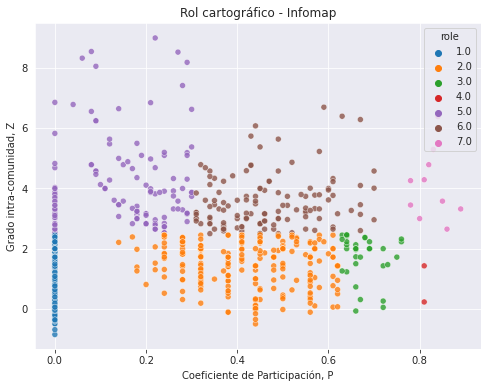

In [198]:
fig,ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=bert_roles, x="participation_coefficient", y="intra_degree", hue="role", ax=ax, palette="tab10", alpha=0.8)
ax.set_xlabel("Coeficiente de Participación, P")
ax.set_ylabel("Grado intra-comunidad, Z")
ax.set_title("Rol cartográfico - Infomap")
fig.savefig(reports_comunidades+"scatter_rol_cartografico_infomap.png",dpi=200)

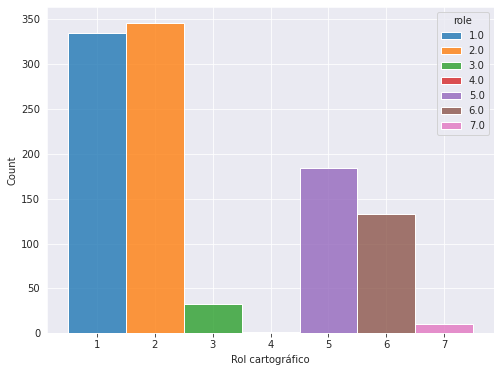

In [199]:
fig,ax = plt.subplots(figsize=(8,6))
sns.histplot(data=bert_roles, x="role", hue="role", palette="tab10", alpha=0.8, ax=ax, discrete=True)
ax.set_xlabel("Rol cartográfico")
fig.savefig(reports_comunidades+"barras_rol_cartografico_infomap.png",dpi=200)

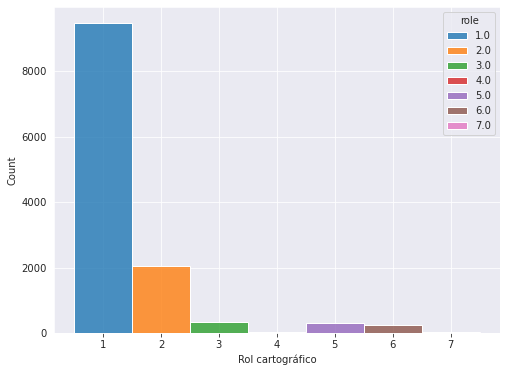

In [200]:
fig,ax = plt.subplots(figsize=(8,6))
sns.histplot(data=results_df, x="role", hue="role", palette="tab10", alpha=0.8, ax=ax, discrete=True)
ax.set_xlabel("Rol cartográfico")
fig.savefig(reports_comunidades+"barras_rol_cartografico_infomap_todos.png",dpi=200)

# Cartographic Role - Louvain

In [206]:
grafos_comunidades = {}

for comunidad in comunidades_louvain:
    nodos = graph_node_data.loc[graph_node_data.comunidades_louvain == comunidad, "node_index"].values
    edges = graph_edge_data.loc[graph_edge_data.y_index.isin(nodos) & graph_edge_data.x_index.isin(nodos), ["y_index","x_index"]].reset_index(drop=True)
    H = nx.from_pandas_edgelist(edges,source="x_index",target="y_index")
    grafos_comunidades[comunidad] = H

In [207]:
k_medio = {}
for comunidad,grafo in grafos_comunidades.items():
    H = grafo
    num_nodes = H.number_of_nodes()
    k_values = np.array([k for (node,k) in list(H.degree())])
    avg_k = np.round(np.mean(k_values),2)
    std_k = np.round(np.std(k_values),2)
    k_medio[comunidad] = {"avg_k":avg_k, "std_k":std_k}

In [208]:
z_score = {}

for comunidad, H in grafos_comunidades.items():
    degrees = dict(H.degree())
    for node, k_i in degrees.items():
        k_si = k_medio[comunidad]["avg_k"]
        sigma_k = k_medio[comunidad]["std_k"]
        node_z_score = round((k_i - k_si)/sigma_k,2)
        z_score[node] = node_z_score

/tmp/ipykernel_4127/3316443242.py:8: RuntimeWarning: invalid value encountered in double_scalars
  node_z_score = round((k_i - k_si)/sigma_k,2)


In [209]:
participation_coefficient = {}
total_degrees = dict(G.degree())

for node in list(G.nodes()):

    node_total_degree = total_degrees[node]
    vecinos = list(G.neighbors(node))
    k_is_dict = enfermedades.set_index("node_index").loc[vecinos,"comunidades_louvain"].astype("int").value_counts().to_dict()

    valores_s = []
    for comunidad, grado_kis in k_is_dict.items():
        sum_term = (grado_kis/node_total_degree)**2
        valores_s.append(sum_term)

    sumatoria = sum(valores_s)
    P_i = round(1 - sumatoria,2)
    participation_coefficient[node] = P_i

In [210]:
cartographic_roles = {}
for node in list(G.nodes()):
    z = z_score[node]
    p = participation_coefficient[node]
    cartographic_roles[node] = cartographic_role(z,p)

In [211]:
cartography_series = pd.Series(cartographic_roles, name="role")
z_score_series = pd.Series(z_score, name="intra_degree")
participation_series = pd.Series(participation_coefficient, name="participation_coefficient")
results_df = pd.DataFrame([cartography_series,z_score_series,participation_series]).T

In [212]:
berts = graph_node_data.loc[graph_node_data.node_type == "bert_group", "node_index"].values
bert_roles = results_df.loc[berts]

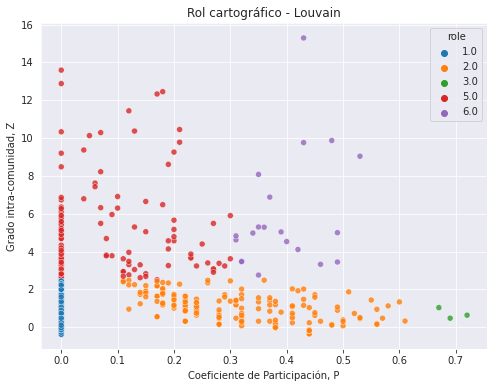

In [213]:
fig,ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=bert_roles, x="participation_coefficient", y="intra_degree", hue="role", ax=ax, palette="tab10", alpha=0.8)
ax.set_xlabel("Coeficiente de Participación, P")
ax.set_ylabel("Grado intra-comunidad, Z")

ax.set_title("Rol cartográfico - Louvain")
fig.savefig(reports_comunidades+"scatter_rol_cartografico_louvain.png",dpi=200)

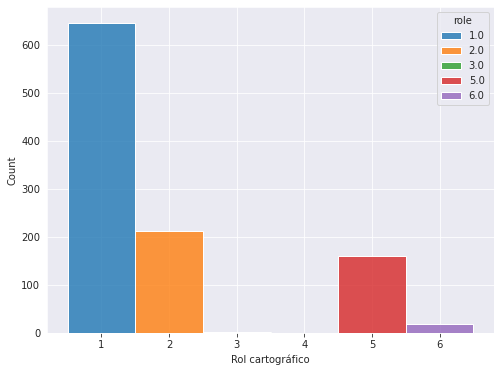

In [214]:
fig,ax = plt.subplots(figsize=(8,6))
sns.histplot(data=bert_roles, x="role", hue="role", palette="tab10", alpha=0.8, ax=ax, discrete=True)
ax.set_xlabel("Rol cartográfico")
fig.savefig(reports_comunidades+"barras_rol_cartografico_louvain.png",dpi=200)

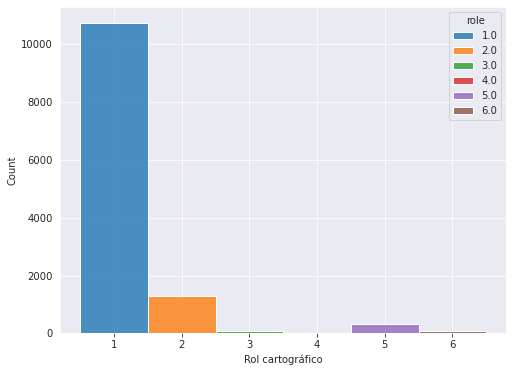

In [215]:
fig,ax = plt.subplots(figsize=(8,6))
sns.histplot(data=results_df, x="role", hue="role", palette="tab10", alpha=0.8, ax=ax, discrete=True)
ax.set_xlabel("Rol cartográfico")
fig.savefig(reports_comunidades+"barras_rol_cartografico_louvain_todos.png",dpi=200)